<center><b>Backpropagation algorithm</b></center>
<center><b>MNIST digit data classification</b></center>

In [1]:
#Download the MNIST data

import urllib.request
import os
import gzip
import numpy as np

def extractData(fileName, isData):
    if os.path.exists(fileName):
        print(fileName)
        if isData:
            offsetBit = 16 #Offset byte is 16 for data as per description
        else:
            offsetBit = 8 #Offset byte is 8 for labels as per description
        with gzip.open(fileName, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset = offsetBit)
        return data
    
def getData(fileName, URL, isData=True):
    if not os.path.exists(fileName):
        print("Downloading file: ", fileName)
        urllib.request.urlretrieve(URL + fileName, fileName)
    else:
        print("File already exists.")
    return extractData(fileName, isData)
    
def loadData(isTrain):
    URL = 'http://yann.lecun.com/exdb/mnist/'
    if isTrain:
        dataFile = 'train-images-idx3-ubyte.gz'
        labelsFile = 'train-labels-idx1-ubyte.gz'
    else:
        dataFile = 't10k-images-idx3-ubyte.gz'
        labelsFile = 't10k-labels-idx1-ubyte.gz'
    return getData(dataFile, URL), getData(labelsFile, URL, False)

trainDataX, trainDataY = loadData(True)
testDataX, testDataY = loadData(False)

File already exists.
train-images-idx3-ubyte.gz
File already exists.
train-labels-idx1-ubyte.gz
File already exists.
t10k-images-idx3-ubyte.gz
File already exists.
t10k-labels-idx1-ubyte.gz


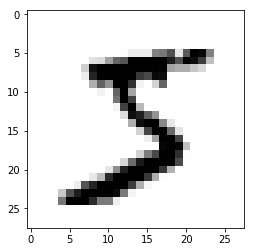

In [3]:
#Reshaping the linear data into matrices

trainDataSize = 60000
testDataSize = 10000
imgSizeX = 28
imgSizeY = 28

trainX = trainDataX.reshape(trainDataSize, imgSizeX * imgSizeY)
trainY = trainDataY.reshape(trainDataSize, 1)
testX = testDataX.reshape(testDataSize, imgSizeX * imgSizeY)
testY = testDataY.reshape(testDataSize, 1)
import matplotlib.pyplot as plt
plt.imshow(trainX[0].reshape(28, 28), cmap='gray_r')

In [4]:
#Input normalization
trainX = trainX/255
testX = testX/255

In [5]:
#Convert labels to one-hot encoded vectors

def getVectorForOutput(y, length):
    return np.array([1 if i == y else 0 for i in range(length)])

def oneHotEncode(Y, size):
    yMatrix = np.zeros((size, Y.shape[0]))
    i = 0
    for entry in Y:
        yMatrix[:, i] = getVectorForOutput(entry, size)
        i += 1
    return yMatrix

trainY = oneHotEncode(trainY, 10)
testY = oneHotEncode(testY, 10)

In [6]:
import math
from random import gauss

def initWeights(shape, incomingConnectionsCount):
    mean_val = 0
    variance_val = 1/incomingConnectionsCount

    #Weights generated using independent identically distributed random variables with mean 0 and variance 1/incomingConnectionsCount
    W = np.random.normal(mean_val, math.sqrt(variance_val), shape[0] * shape[1])
    W = np.asarray(W).reshape(shape[0], shape[1])
    
    b = np.random.normal(mean_val, math.sqrt(variance_val), shape[0] * 1)
    b = np.asarray(b).reshape(shape[0], 1)
    
    return W, b

In [7]:
#activation functions
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derv(s_z):
    return s_z * (1 - s_z)

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [8]:
trainX2 = trainX.copy()
testX2 = testX.copy()
trainX = trainX.T
testX = testX.T

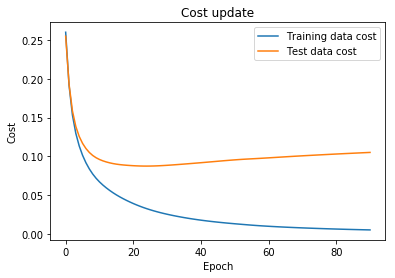

Minimized cost: 0.0051372410721588916
Number of epochs: 91


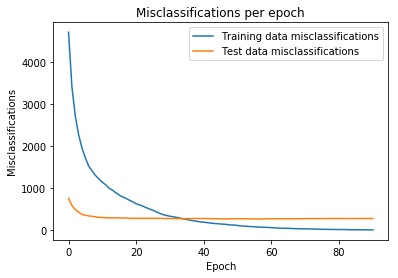

Final number of misclassifications on training data: 12
Final number of misclassifications on test data: 283


In [22]:
def plotCost(trainCost, testCost):
    plt.plot(range(len(trainCost)), trainCost, label = "Training data cost")
    plt.plot(range(len(testCost)), testCost, label = "Test data cost")
    plt.title("Cost update")
    plt.xlabel("Epoch")
    plt.ylabel("Cost")
    plt.legend(loc='upper right')
    plt.show()
    
def plotMisclassifications(misclassificationsTrain, misclassificationsTest):
    plt.plot(range(len(misclassificationsTrain)), misclassificationsTrain, label = "Training data misclassifications")
    plt.plot(range(len(misclassificationsTest)), misclassificationsTest, label = "Test data misclassifications")
    plt.title("Misclassifications per epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Misclassifications")
    plt.legend(loc='upper right')
    plt.show()

def compute_loss(d, Y):
    return - 1 / d.shape[1] * np.sum(np.multiply(d, np.log(Y)))

def trainModel(X, y, testX, testY):
    #eta1 = 1 / math.sqrt(784) * 1
    #eta2 = 1 / math.sqrt(100) * 0.5
    eta1 = eta2 = 0.5
    
    batch_size = 60
    batches = X.shape[1] // batch_size + 1
    
    #Adding hidden layers
    W1, b1 = initWeights([50, X.shape[0]], X.shape[0])
    W2, b2 = initWeights([10, 50], 50)
    
    epoch = 0
    cost_tracker = []
    cost_tracker_test = []
    misclassifications_counter = []
    misclassifications_counter_test = []
    
    while True:
        for i in range(batches):
            start_batch = i * batch_size
            end_batch = start_batch + batch_size
            cur_batch_size = end_batch - start_batch
            if end_batch >= X.shape[1]:
                end_batch = X.shape[1]
                cur_batch_size = end_batch - start_batch
            X_batch = X[:, start_batch:end_batch]
            Y_batch = y[:, start_batch:end_batch]
        
            #Forward pass
            a1_induced = np.matmul(W1, X_batch) + b1
            a1_activated = sigmoid(a1_induced)

            a2_induced = np.matmul(W2, a1_activated) + b2
            a2_activated = softmax(a2_induced)

            #Backward pass
            a2_backward = 1
            a1_backward = sigmoid_derv(a1_activated)
            
            #Weights update
            y_prime = Y_batch - a2_activated
        
            dEdW22 = - 1 / batch_size * np.matmul(y_prime, a1_activated.T) * a2_backward
            dEdb22 = - 1 / batch_size * np.sum(y_prime, axis = 1, keepdims = True)

            tempVal = np.matmul(W2.T, y_prime) * a1_backward
            dEdW11 = - 1 / batch_size * (np.matmul(tempVal, X_batch.T))
            dEdb11 = - 1 / batch_size * np.sum(tempVal, axis = 1, keepdims = True)

            W1 = W1 - (eta1 * dEdW11)
            b1 = b1 - (eta1 * dEdb11)
            W2 = W2 - (eta2 * dEdW22)
            b2 = b2 - (eta2 * dEdb22)
        
        epoch += 1
        
        #Cost calculation
        #Train data
        a1_induced = np.matmul(W1, X) + b1
        a1_activated = sigmoid(a1_induced)

        a2_induced = np.matmul(W2, a1_activated) + b2
        a2_activated = softmax(a2_induced)
        
        cost = compute_loss(y, a2_activated)
        cost_tracker.append(cost)
        
        predictedY = a2_activated
        count = 0
        for i in range(X.shape[1]):
            if np.argmax(y[:, i]) != np.argmax(predictedY[:, i]):
                count += 1
        misclassifications_counter.append(count)
        
        #Test data
        a1_induced = np.matmul(W1, testX) + b1
        a1_activated = sigmoid(a1_induced)

        a2_induced = np.matmul(W2, a1_activated) + b2
        a2_activated = softmax(a2_induced)
        
        cost = compute_loss(testY, a2_activated)
        cost_tracker_test.append(cost)
        
        predictedY = a2_activated
        count = 0
        for i in range(testX.shape[1]):
            if np.argmax(testY[:, i]) != np.argmax(predictedY[:, i]):
                count += 1
        misclassifications_counter_test.append(count)
        
        if len(cost_tracker) > 1:
            if abs(cost_tracker[-1] - cost_tracker[-2]) < 1e-4:
                break
            elif cost_tracker[-1] > cost_tracker[-2]: #divergence detected -> reduce learning rate
                eta1 -= 0.1 * eta1
            
    return W1, b1, W2, b2, cost_tracker, cost_tracker_test, misclassifications_counter, misclassifications_counter_test
    
W1, b1, W2, b2, cost_tracker, cost_tracker_test, misclassifications_counter, misclassifications_counter_test = trainModel(trainX, trainY, testX, testY)
plotCost(cost_tracker, cost_tracker_test)
print("Minimized cost:", cost_tracker[-1])
print("Number of epochs:", len(cost_tracker))
plotMisclassifications(misclassifications_counter, misclassifications_counter_test)
print("Final number of misclassifications on training data:", misclassifications_counter[-1])
print("Final number of misclassifications on test data:", misclassifications_counter_test[-1])

In [24]:
#Calculating final accuracies
training_accuracy = (trainX.shape[1] - misclassifications_counter[-1]) / trainX.shape[1] * 100
test_accuracy = (testX.shape[1] - misclassifications_counter_test[-1]) / testX.shape[1] * 100

print("Training accuracy: ", training_accuracy)
print("Test accuracy: ", test_accuracy)

Training accuracy:  99.98
Test accuracy:  97.17
